The detials are scraped from the website : https://phonedb.net/

In [15]:
from bs4 import BeautifulSoup
import pandas as pd
import aiohttp
import asyncio
from pathlib import Path
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

  0%|          | 15/7938 [00:30<48:38,  2.71it/s]

In [ ]:
def get_phone_db_link(filter: int = 0) -> str:
    return fr'https://phonedb.net/index.php?m=device&s=list&filter={filter}'

async def get_phone_db_page(session: aiohttp.ClientSession, filter: int = 0) -> None:
    async with session.get(get_phone_db_link(filter)) as response:
        # write to a file with filter as the name
        with open(f'./data/{filter}.html', 'w', encoding='utf-8') as f:
            f.write(await response.text())


async def get_phone_db_pages(session: aiohttp.ClientSession, filters: list[int]) -> None:
    return await asyncio.gather(*[get_phone_db_page(session, filter) for filter in filters])

async def main():
    async with aiohttp.ClientSession() as session:
        await get_phone_db_pages(session, range(29*200, 29*300, 29))

await main()


In [ ]:
from typing import Union

def extract_phone_db_content(content_block: list) -> Union[dict, None]:
    if len(content_block) < 4 or content_block is None: return None
    return {
        'id': hash(content_block[0].text),
        'title': content_block[0].text,
        'img_link': content_block[1].img['src'],
        'phone_link': content_block[2]['href']
    }
def get_phone_db_page_content(page_html: str) -> list:
    soup = BeautifulSoup(page_html, 'html.parser')
    content_blocks = soup.find_all('div', class_='content_block')
    return [content_block.find_all('a') for content_block in content_blocks]

In [ ]:
# open all the html files in data\root_page_data and extract the content
from tqdm.notebook import tqdm

def get_phone_db_content() -> list:
    content = []
    err_files = []
    p = Path("./data/root_page_data/")
    pbar = tqdm(total=300)

    for file_name in p.glob("*.html"):
        pbar.update(1); print("", end="")
        with open(file_name, 'r', encoding='utf-8') as f:
            page_content_list = get_phone_db_page_content(f.read())
            try:
                extraced_content = [extract_phone_db_content(content_block) for content_block in page_content_list]
            except TypeError:
                err_files.append(file_name)
            content.extend(extraced_content)

    pbar.close()
    print(f"Error files: {err_files}")
    return content

phone_db_content = get_phone_db_content()

In [ ]:
for k, v in phone_db_content[0].items():
    print(f"{k}: {v}")

In [ ]:
phone_db_content = [content for content in phone_db_content if content is not None]
# df = pd.DataFrame(phone_db_content)
# df.to_csv('./data/phone_db_content.csv', index=False)

In [ ]:
# get the filenames from data/single_phone_page_data

# from pathlib import Path

# p = Path("./data/single_phone_page_data/")
# file_names_lst = [file_name for file_name in p.glob("*.html")]
# file_names_id_lst = [int(file_name.stem) for file_name in file_names_lst]
# file_names_id_lst[1:10]

In [ ]:
# phone_db_content = [content for content in phone_db_content if content['id'] not in file_names_id_lst]

In [ ]:
from tqdm.notebook import tqdm

async def get_single_page_html(session: aiohttp.ClientSession, ph_dict: dict[str, str]) -> None:
    link = "https://phonedb.net/" + ph_dict['phone_link']
    _id = ph_dict['id']
    async with session.get(link) as response:
        with open(f'./data/single_phone_page_data/{_id}.html', 'w', encoding='utf-8') as f:
            f.write(await response.text())
    
async def get_phone_pages(session: aiohttp.ClientSession, phone_db_content: list[dict[str, str]]) -> None:
    return await asyncio.gather(*[get_single_page_html(session, ph_dict) for ph_dict in phone_db_content])

timeout_mins = aiohttp.ClientTimeout(20 * 60)
async def main():
    async with aiohttp.ClientSession(timeout=timeout_mins) as session:
        await get_phone_pages(session, phone_db_content)

await main()


In [3]:
p = Path("./data/single_phone_page_data/")
file_names_lst = [file_name for file_name in p.glob("*.html")]

In [ ]:
def get_single_phone_page_content(page_html: str) -> pd.DataFrame:
    df = pd.read_html(page_html)
    return df[0]

def save_phone_content(df: pd.DataFrame, file_name: str) -> None:
    df.to_csv(f'./data/individual_phone_data/{file_name}.csv', index=False)

def parse_single_phone_page(file_name: Path) -> None:
    with open(file_name, 'r', encoding='utf-8') as f:
        df = get_single_phone_page_content(f.read())
        save_phone_content(df, file_name.stem)
        return True
    
from tqdm.notebook import tqdm

ex_list = []
pbar = tqdm(total=len(file_names_lst))
for file_name in file_names_lst:
    try: 
        pbar.update(1)
        parse_single_phone_page(file_name)
    except ValueError: # i.e no table in the html
        ex_list.append(file_name)
    

print(ex_list)

In [4]:
# read all the files from data/individual_phone_data
p = Path("./data/individual_phone_data/")
file_names_lst = [file_name for file_name in p.glob("*.csv")]

def transorm_df(df: pd.DataFrame, _id: int) -> pd.DataFrame:
    df = df.T
    df.columns = df.iloc[0]
    df = df.drop(df.index[0])
    df = df.reset_index()
    df = df.drop(columns=['index', 'Introduction:'])
    return df

# create a list of dataframes
df_lst = []
for file_name in file_names_lst:
    new_df = transorm_df( pd.read_csv(file_name), int(file_name.stem) )
    df_lst.append(new_df)

In [5]:
columns = [
    "Brand", "Model", "Brief", "Released", "Announced",
    "Width", "Height", "Depth", "Weight", "Platform",
    "Operating System", "CPU Clock", "CPU", "RAM Type", "RAM Capacity",
    "Display Diagonal", "Display Resolution", "Pixel Size", "Display Type",
    "Display Width", "Display Height", "Display Refresh Rate", "Display Colors", "Supported Cellular Bands",
    "Supported Cellular Networks", "Expansion Interfaces", "USB", "USB Services", "USB Connector",
    "Bluetooth profiles", "Wireless LAN", "WLAN Controller IC", "NFC",
    "Supported GPS protocol(s)", "Camera Resolution", "Number of effective pixels", "Aperture (W)",
    "Secondary Camera Resolution", "Secondary Camera Number of effective pixels", "Secondary Camera Aperture (W)", "Battery",
    "Nominal Cell Voltage (1st cell)", "Nominal Cell Capacity (1st cell)", "Estimated Battery Life"
]

tst_lst_df = []
for df in df_lst:
    # fill null if the column isn't found 
    for col in columns:
        if col not in df.columns:
            df[col] = np.nan
    tst_lst_df.append(df)
# Video Recording
# 2nd vid rec

In [6]:
df_lst_filtered = [  df[df.columns.intersection(columns)] for df in df_lst ]
tst_lst_df = pd.concat(df_lst_filtered, ignore_index=True)

In [10]:
df_merged = pd.concat(df_lst_filtered, ignore_index=True)

<AxesSubplot:xlabel='0'>

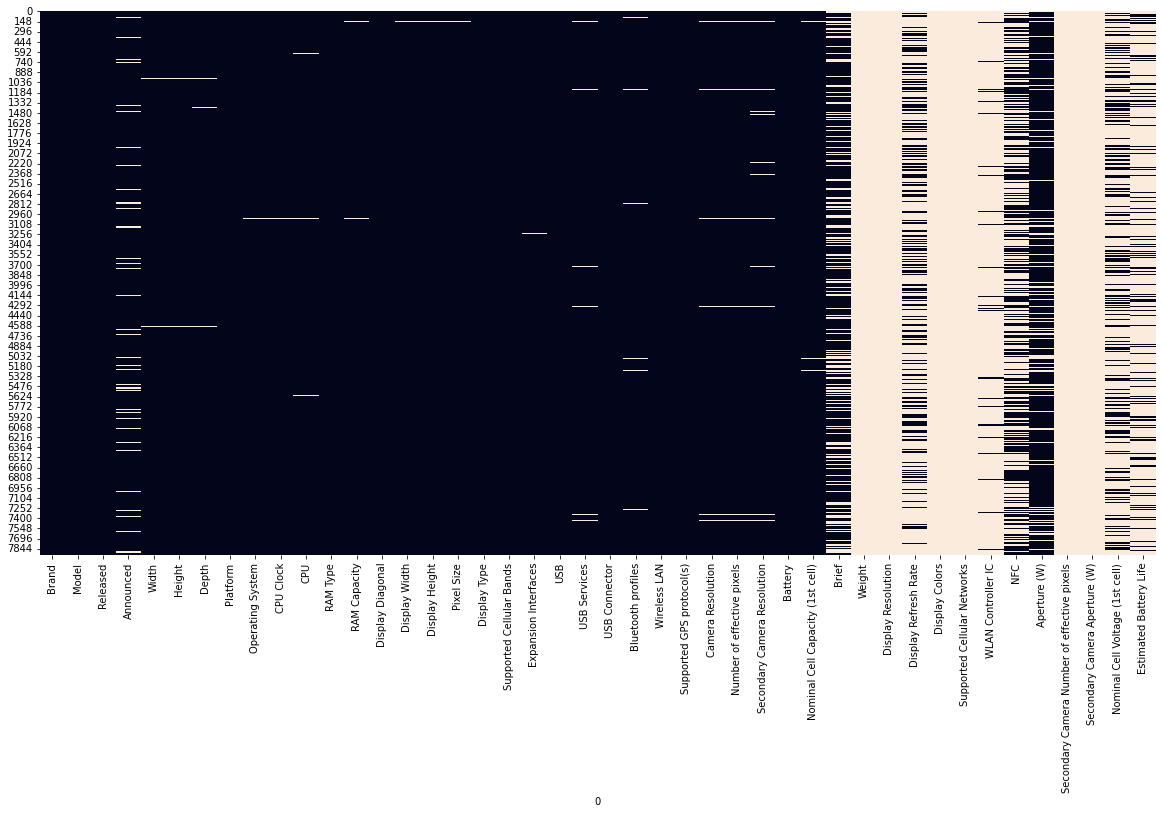

In [7]:
# increase plot size
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
sns.heatmap(tst_lst_df.isnull(), cbar=False)

In [79]:
cols = [
    "Video Recording",
    "Secondary Video Recording"
]

tst_df_lst = df_lst.copy()

# get the index and merge the next  index data with the  current index data
for i in range(len(tst_df_lst)):
    for col in cols:
        if col in tst_df_lst[i].columns:
            idx = tst_df_lst[i].columns.get_loc(col)
            tst_df_lst[i].iloc[:, idx] = tst_df_lst[i].iloc[:, idx] + tst_df_lst[i].iloc[:, idx + 1]
            tst_df_lst[i] = tst_df_lst[i].drop(columns=[tst_df_lst[i].columns[idx + 1]])


Index(['Brand', 'Model', 'Released', 'Announced', 'Manufacturer',
       'General Extras', 'Device Category',
       'Collapse datasheet | Add to compare Physical Attributes:', 'Width',
       'Height',
       ...
       'Power Supply:', 'Battery', 'Nominal Cell Capacity (1st cell)',
       'Geographical Attributes:', 'Market Countries', 'Market Regions',
       'Datasheet Attributes:', 'Data Integrity', 'Added', 'id'],
      dtype='object', name='0', length=135)

In [82]:
df_lst = tst_df_lst.copy()
# filter out the columns that are not in the columns list in the df_lst 
df_lst_filtered = [  df[df.columns.intersection(columns)] for df in df_lst ]

In [83]:
df_merged = pd.concat(df_lst_filtered, ignore_index=True)

In [9]:
df_merged.to_csv('./data/phone_db_merged.csv', index=False)

In [119]:
df_merged["Model"].str.split("Sim", expand=True)[0].str.split("SIM", expand=True)[0].str.replace("Dual", "")

0                             Compass Z516
1                           Honor 9 Lite  
2                          BV7000 Pro 4G  
3                             7.2 Global  
4                    Z6 Standard Edition  
                       ...                
7933    SM-J250N Galaxy J2 Pro 2018 LTE KR
7934                          Xperia XZ1  
7935                             S5 Plus  
7936                             P2 Lite  
7937    Redmi Note 8 Pro Premium Edition  
Name: 0, Length: 7938, dtype: object

In [11]:
# get the phone names 
# split model 
# get the index until you find sim 

model_names = (df_merged['Model']
    .str
    .split('SIM', expand=True)[0]
    .str
    .replace('Dual', "")
    .str
    .split('Sim', expand=True)[0]
    )

In [77]:
failed_lst = []
pbar = tqdm(total=len(model_names))

def get_flipkar_link(phone_name: str) -> str:
    return f'https://www.flipkart.com/search?q={phone_name}'

async def get_phone_price(session:aiohttp.ClientSession, phone_name: str) -> str:
    flipkart_link = get_flipkar_link(phone_name)
    async with session.get(flipkart_link) as response:
        soup = BeautifulSoup(await response.text(), 'html.parser')
        try:
            price = soup.find('div', {'class': '_30jeq3 _1_WHN1'}).text
        except AttributeError:
            failed_lst.append(phone_name)
            price = np.nan
        pbar.update(1)
        return price

async def get_phone_prices(session:aiohttp.ClientSession, phone_names: list) -> list:
    prices = await asyncio.gather(*[get_phone_price(session, phone_name) for phone_name in phone_names])
    return prices

timeout_mins = aiohttp.ClientTimeout( 20 * 60 )
async def fetch_phone_data(phones_names: list):
    async with aiohttp.ClientSession(timeout=timeout_mins) as session:
        prices = await get_phone_prices(session, phones_names)
        return prices

phones_names = df_merged['Brand'] + ' ' + model_names
prices = await fetch_phone_data(phones_names)

  0%|          | 0/7938 [00:00<?, ?it/s]

In [17]:
print(len(failed_lst))
print(len(df_merged))

4082
7938


In [18]:
# merge prices and df_merged 
df_merged['Price'] = prices

In [43]:
# drop the row if brand and  model are none
_df_merged = df_merged.dropna(subset=['Brand', 'Model', "Released"])
_df_merged.shape, df_merged.shape
df_merged = _df_merged.copy()

In [47]:
def get_long_month(month: str) -> str:
    short_long_year_dict = {
        "Jan" : "January",
        "Feb" : "February",
        "Mar" : "March",
        "Apr" : "April",
        "May" : "May",
        "Jun" : "June",
        "Jul" : "July",
        "Aug" : "August",
        "Sep" : "September",
        "Oct" : "October",
        "Nov" : "November",
        "Dec" : "December"
    }

    return short_long_year_dict[month]

In [ ]:
df_merged

In [53]:
# split the string of date into year, month, day
_split_data = df_merged['Released'].str.split(' ', expand=True)
_split_data.fillna("Jan", inplace=True)
year_col = _split_data[0]
month_col = _split_data[1].apply(get_long_month)

df_merged["Released Year"] = year_col
df_merged["Released Month"] = month_col

In [55]:
# sort df_merged on basis of  released year and month
df_merged_date_sorted  = df_merged.sort_values(by=['Released Year', 'Released Month'])

<AxesSubplot:xlabel='0'>

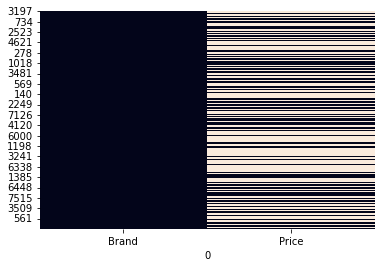

In [63]:
data = df_merged_date_sorted[["Brand", "Price"]].isna()
sns.heatmap(data, cbar=False)

In [68]:
# find the length of phones before year 2017
df_merged_date_sorted[df_merged_date_sorted['Released Year'] < '2017'].shape

(230, 47)

In [72]:
# collect the brands that have price as nan
df_merged_price_nan = df_merged.loc[df_merged['Price'].isna()]

In [74]:
df_merged_price_nan.shape

(4078, 47)

In [78]:
phones_names = df_merged_price_nan['Brand'] + ' ' + df_merged_price_nan["Model"]
prices = await fetch_phone_data(phones_names)

In [82]:
df_merged_price_nan['Price'] = prices

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22340\3752623202.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_price_nan['Price'] = prices


In [89]:
# print not null values in the table
df_merged_price_nan[df_merged_price_nan['Price'].notnull()]

0,Brand,Model,Released,Announced,Width,Height,Depth,Platform,Operating System,CPU Clock,...,WLAN Controller IC,NFC,Aperture (W),Secondary Camera Number of effective pixels,Secondary Camera Aperture (W),Nominal Cell Voltage (1st cell),Estimated Battery Life,Price,Released Year,Released Month
17,Oppo,Realme GT Master Premium Edition 5G Dual SIM T...,2021 Aug 26,2021 Aug 17,73.5 mm,159.2 mm,8.7 mm,Google Android,Google Android 11 (R),2400 MHz,...,NaN,"NFC A , NFC B",f/1.80,NaN,NaN,NaN,NaN,"₹29,999",2021,August
30,LG,G8X ThinQ TD-LTE JP 901LG,2019 Dec 6,2019 Oct 17,76 mm,160 mm,8.4 mm,Google Android,Google Android 9.0 (Pie),2842 MHz,...,NaN,"NFC A , NFC B",f/1.80,NaN,NaN,NaN,NaN,"₹55,000",2019,December
54,Highscreen,Easy S Dual SIM,2015 Nov,NaN,71.5 mm,143 mm,8.5 mm,Google Android,Google Android 6.0 (Marshmallow),1300 MHz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"₹7,999",2015,November
61,Samsung,SM-R800 Galaxy Watch 46mm WiFi,2018 Sep 2,2018 Aug 9,46 mm,49 mm,13 mm,Linux,Samsung Tizen Wearable Platform,1150 MHz,...,NaN,Yes,NaN,NaN,NaN,NaN,NaN,"₹34,890",2018,September
65,Intex,Aqua Note 5.5 Dual SIM TD-LTE,2017 Oct 4,2017 Sep 1,77.5 mm,153 mm,10.3 mm,Google Android,Google Android 7.0 (Nougat),1250 MHz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"₹7,490",2017,October
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7834,Samsung,SM-A226B/DSN Galaxy A22 5G 2021 Global Dual SI...,2021 Jul,2021 Jun 3,77.6 mm,167.2 mm,9 mm,Google Android,Google Android 11 (R),2200 MHz,...,NaN,"NFC A , NFC B",f/1.80,NaN,NaN,NaN,NaN,"₹59,999",2021,July
7856,OnePlus,6 Dual SIM Global TD-LTE A6003 256GB,2018 May 22,2018 May 16,75.35 mm,155.7 mm,7.75 mm,Google Android,Google Android 8.1 (Oreo),2800 MHz,...,Qualcomm WCN3990,"NFC A , NFC B",NaN,NaN,NaN,3.85 Volts,NaN,"₹42,999",2018,May
7865,Google,Pixel 6 Pro 5G Global TD-LTE 128GB GLUOG,2021 Oct 28,2021 Oct 19,75.9 mm,163.9 mm,8.9 mm,Google Android,Google Android 12 (S),2800 MHz,...,Broadcom BCM4389,"NFC A , NFC B",f/1.85,NaN,NaN,NaN,48.0 hours,"₹84,999",2021,October
7894,BBK,Vivo Y20T 2021 Dual SIM TD-LTE IN 64GB V2129,2021 Oct,2021 Oct 11,76.32 mm,164.41 mm,8.41 mm,Google Android,Google Android 11 (R),2000 MHz,...,NaN,NaN,f/2.20,NaN,NaN,NaN,NaN,"₹15,890",2021,October


In [84]:
df_merged = df_merged.merge(df_merged_price_nan, how='outer')

In [94]:
df_merged.to_csv('./data/phone_db_merged_with_nulls.csv', index=False)

In [95]:
df_merged.dropna(subset=['Price'], inplace=True)
df_merged.to_csv('./data/phone_db_merged_no_price_nulls.csv', index=False)

In [54]:
df_merged.head()

0,Brand,Model,Released,Announced,Width,Height,Depth,Platform,Operating System,CPU Clock,...,WLAN Controller IC,NFC,Aperture (W),Secondary Camera Number of effective pixels,Secondary Camera Aperture (W),Nominal Cell Voltage (1st cell),Estimated Battery Life,Price,Released Year,Released Month
0,Plum Mobile,Compass Z516,2017 Jan 12,2016 Dec,72.6 mm,146 mm,9.8 mm,Google Android,Google Android 6.0 (Marshmallow),1300 MHz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,January
1,Huawei,Honor 9 Lite Dual SIM TD-LTE CN 32GB LLD-AL10 ...,2017 Dec 26,2017 Dec 21,71.9 mm,151 mm,7.6 mm,Google Android,Google Android 8.0 (Oreo),2362 MHz,...,NaN,NaN,NaN,NaN,NaN,3.82 Volts,NaN,"₹16,949",2017,December
2,Blackview,BV7000 Pro 4G Dual Sim LTE-A,2017 Feb,2017 Feb,78.9 mm,153 mm,12.6 mm,Google Android,Google Android 7.0 (Nougat),1510 MHz,...,NaN,NaN,f/2.00,NaN,NaN,NaN,NaN,₹799,2017,February
3,Nokia,7.2 Global Dual SIM TD-LTE 128GB,2019 Sep 23,2019 Sep 16,75.15 mm,159.92 mm,8.25 mm,Google Android,Google Android 9.0 (Pie),2200 MHz,...,NaN,"NFC A , NFC B",f/1.80,NaN,NaN,NaN,NaN,"₹1,692",2019,September
4,Lenovo,Z6 Standard Edition Dual SIM TD-LTE CN 128GB L...,2019 Jul 4,2019 Jul 1,74.5 mm,157 mm,7.97 mm,Google Android,Google Android 9.0 (Pie),2200 MHz,...,NaN,NaN,f/1.80,NaN,NaN,3.85 Volts,NaN,"₹1,199",2019,July
